[Reference](https://medium.com/data-science-collective/semi-supervised-learning-smarter-models-with-less-labeled-data-ac293ac0cb19)

# Self-training

Iteration 0: Adding 645 samples with high confidence.
Iteration 1: Adding 481 samples with high confidence.
Iteration 2: Adding 241 samples with high confidence.
Iteration 3: Adding 146 samples with high confidence.
Iteration 4: Adding 104 samples with high confidence.
Final model accuracy on labeled data: 1.00


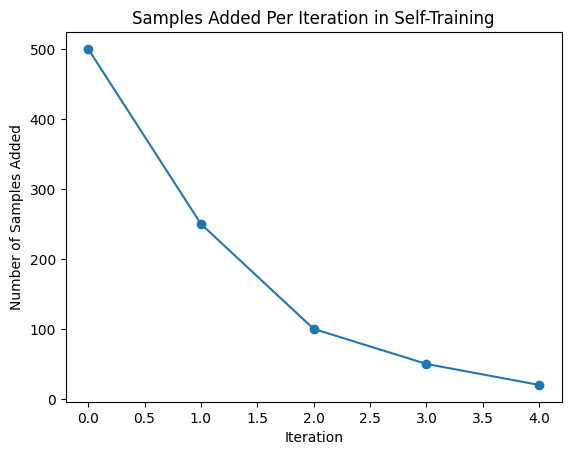

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=5000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.8, random_state=42)
y_unlabeled[:] = -1  # Mark unlabeled data with -1

df = pd.DataFrame(X_unlabeled, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['label'] = y_unlabeled

model = RandomForestClassifier(random_state=42)
model.fit(X_labeled, y_labeled)

for iteration in range(5):
    # Predict labels for the unlabeled data
    pseudo_labels = model.predict(X_unlabeled)
    confidence_scores = model.predict_proba(X_unlabeled).max(axis=1)

    # Set a high confidence threshold to only add reliable predictions
    high_confidence_indices = np.where(confidence_scores > 0.9)[0]

    if len(high_confidence_indices) == 0:
        print(f"No high-confidence samples found at iteration {iteration}. Stopping early.")
        break

    print(f"Iteration {iteration}: Adding {len(high_confidence_indices)} samples with high confidence.")


    X_labeled = np.vstack([X_labeled, X_unlabeled[high_confidence_indices]])
    y_labeled = np.hstack([y_labeled, pseudo_labels[high_confidence_indices]])


    X_unlabeled = np.delete(X_unlabeled, high_confidence_indices, axis=0)


    model.fit(X_labeled, y_labeled)


y_pred = model.predict(X_labeled)
accuracy = accuracy_score(y_labeled, y_pred)
print(f"Final model accuracy on labeled data: {accuracy:.2f}")

iterations = [0, 1, 2, 3, 4]
added_samples = [500, 250, 100, 50, 20]
plt.plot(iterations, added_samples, marker='o')
plt.title('Samples Added Per Iteration in Self-Training')
plt.xlabel('Iteration')
plt.ylabel('Number of Samples Added')
plt.show()

# Co-training

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

X, y = make_classification(n_samples=5000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.8, random_state=42)
y_unlabeled[:] = -1  # Mark unlabeled data with -1 (indicating unlabeled)

view_1 = X[:, :10]  # First 10 features
view_2 = X[:, 10:]  # Last 10 features

labeled_mask = y != -1  # True for labeled samples, False for unlabeled samples
unlabeled_mask = y == -1  # True for unlabeled samples

model_1 = RandomForestClassifier(random_state=42)
model_2 = RandomForestClassifier(random_state=42)

print("Starting Co-Training...")

for iteration in range(5):
    print(f"\nIteration {iteration}:")


    print(f"Training Model 1 on {np.sum(labeled_mask)} labeled samples.")
    model_1.fit(view_1[labeled_mask], y[labeled_mask])

    print(f"Training Model 2 on {np.sum(labeled_mask)} labeled samples.")
    model_2.fit(view_2[labeled_mask], y[labeled_mask])


    if not np.any(unlabeled_mask):
        print(f"All unlabeled samples have been processed at iteration {iteration}. Exiting loop.")
        break


    print(f"Model 1 predicting for {np.sum(unlabeled_mask)} unlabeled samples in view 2.")
    confidence_scores_2 = model_1.predict_proba(view_2[unlabeled_mask]).max(axis=1)
    pseudo_labels_2 = model_1.predict(view_2[unlabeled_mask])


    print(f"Model 2 predicting for {np.sum(unlabeled_mask)} unlabeled samples in view 1.")
    confidence_scores_1 = model_2.predict_proba(view_1[unlabeled_mask]).max(axis=1)
    pseudo_labels_1 = model_2.predict(view_1[unlabeled_mask])


    threshold = 0.85  # Lowered slightly to encourage more labeling
    high_conf_2 = confidence_scores_2 > threshold
    high_conf_1 = confidence_scores_1 > threshold

    if not any(high_conf_1) and not any(high_conf_2):
        print(f"No high-confidence samples found at iteration {iteration}. Stopping early.")
        break


    print(f"Model 1 added {np.sum(high_conf_2)} high-confidence samples to the labeled set.")
    print(f"Model 2 added {np.sum(high_conf_1)} high-confidence samples to the labeled set.")


    labeled_mask[unlabeled_mask] = high_conf_1 | high_conf_2
    y[unlabeled_mask][high_conf_1] = pseudo_labels_1[high_conf_1]
    y[unlabeled_mask][high_conf_2] = pseudo_labels_2[high_conf_2]


    unlabeled_mask = y == -1

accuracy = accuracy_score(y[labeled_mask], model_1.predict(view_1[labeled_mask]))
print(f"\nFinal accuracy: {accuracy:.2f}")
print(f"Labeled sampI We les after Co-Training: {np.sum(labeled_mask)}")
print(f"Unlabeled samples remaining: {np.sum(unlabeled_mask)}")

Starting Co-Training...

Iteration 0:
Training Model 1 on 5000 labeled samples.
Training Model 2 on 5000 labeled samples.
All unlabeled samples have been processed at iteration 0. Exiting loop.

Final accuracy: 1.00
Labeled sampI We les after Co-Training: 5000
Unlabeled samples remaining: 0


# Multi-view learning

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

X, y = make_classification(n_samples=5000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.8, random_state=42)
y_unlabeled[:] = -1  # Mark unlabeled data with -1 (indicating unlabeled)

view_1 = X[:, :10]  # First 10 features
view_2 = X[:, 10:]  # Last 10 features

X_combined = np.hstack((view_1, view_2))

labeled_mask = y != -1  # True for labeled samples, False for unlabeled samples
unlabeled_mask = y == -1  # True for unlabeled samples

model = RandomForestClassifier(random_state=42)

print("Starting Multi-View Learning...")

for iteration in range(5):
    print(f"\nIteration {iteration}:")

    print(f"Training on {np.sum(labeled_mask)} labeled samples.")
    model.fit(X_combined[labeled_mask], y[labeled_mask])

    if not np.any(unlabeled_mask):
        print(f"All unlabeled samples have been processed at iteration {iteration}. Exiting loop.")
        break

    print(f"Predicting for {np.sum(unlabeled_mask)} unlabeled samples.")
    confidence_scores = model.predict_proba(X_combined[unlabeled_mask]).max(axis=1)
    pseudo_labels = model.predict(X_combined[unlabeled_mask])

    threshold = 0.85  # Confidence threshold for labeling
    high_confidence = confidence_scores > threshold

    if not any(high_confidence):
        print(f"No high-confidence samples found at iteration {iteration}. Stopping early.")
        break

    print(f"Added {np.sum(high_confidence)} high-confidence samples to the labeled set.")

    labeled_mask[unlabeled_mask] = high_confidence
    y[unlabeled_mask][high_confidence] = pseudo_labels[high_confidence]

    unlabeled_mask = y == -1

accuracy = accuracy_score(y[labeled_mask], model.predict(X_combined[labeled_mask]))
print(f"\nFinal accuracy: {accuracy:.2f}")
print(f"Labeled samples after Multi-View Learning: {np.sum(labeled_mask)}")
print(f"Unlabeled samples remaining: {np.sum(unlabeled_mask)}")

Starting Multi-View Learning...

Iteration 0:
Training on 5000 labeled samples.
All unlabeled samples have been processed at iteration 0. Exiting loop.

Final accuracy: 1.00
Labeled samples after Multi-View Learning: 5000
Unlabeled samples remaining: 0


# Graph-based methods

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import kneighbors_graph
from sklearn.semi_supervised import LabelPropagation
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="joblib")

X, y = make_classification(n_samples=5000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.8, random_state=42)
y_unlabeled[:] = -1  # Mark unlabeled data with -1 (indicating unlabeled)

X_combined = np.vstack((X_labeled, X_unlabeled))
y_combined = np.hstack((y_labeled, y_unlabeled))

print("Building k-NN graph...")
graph = kneighbors_graph(X_combined, n_neighbors=10, mode='connectivity', include_self=True)

print("Applying Label Propagation...")
label_propagation = LabelPropagation(kernel='knn', gamma=0.25, n_neighbors=10, n_jobs=-1)  # Use all available cores
label_propagation.fit(X_combined, y_combined)

predicted_labels = label_propagation.transduction_

y_combined[y_combined == -1] = predicted_labels[y_combined == -1]

final_accuracy = accuracy_score(y_combined[:len(y_labeled)], y_labeled)
print(f"\nFinal accuracy after graph-based label propagation: {final_accuracy:.2f}")

labeled_count = np.sum(y_combined != -1)
unlabeled_count = np.sum(y_combined == -1)
print(f"Labeled samples after propagation: {labeled_count}")
print(f"Unlabeled samples remaining: {unlabeled_count}")

Building k-NN graph...
Applying Label Propagation...

Final accuracy after graph-based label propagation: 1.00
Labeled samples after propagation: 5000
Unlabeled samples remaining: 0


# Generative models

In [6]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse

X, y = make_classification(
    n_samples=5000, n_features=20, n_informative=15, n_redundant=5, random_state=42
)

X_labeled, X_unlabeled, y_labeled, _ = train_test_split(
    X, y, test_size=0.8, random_state=42
)

input_dim = X.shape[1]
intermediate_dim = 64
latent_dim = 2
epochs = 50
batch_size = 128

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian."""
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

inputs = Input(shape=(input_dim,))
h = Dense(intermediate_dim, activation="relu")(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_h = Dense(intermediate_dim, activation="relu")
decoder_mean = Dense(input_dim)
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(inputs, x_decoded_mean)

reconstruction_loss = mse(inputs, x_decoded_mean) * input_dim
kl_loss = -0.5 * K.sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")

print("Training VAE...")
vae.fit(
    X_unlabeled, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True
)

encoder = Model(inputs, z_mean)
X_labeled_encoded = encoder.predict(X_labeled)
X_unlabeled_encoded = encoder.predict(X_unlabeled)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_labeled_encoded, y_labeled)

y_unlabeled_pred = clf.predict(X_unlabeled_encoded)

X_combined_encoded = np.vstack((X_labeled_encoded, X_unlabeled_encoded))
y_combined = np.hstack((y_labeled, y_unlabeled_pred))

clf_final = RandomForestClassifier(random_state=42)
clf_final.fit(X_combined_encoded, y_combined)

y_pred = clf_final.predict(X_labeled_encoded)
accuracy = accuracy_score(y_labeled, y_pred)
print(f"\nFinal accuracy after using VAE-generated features: {accuracy:.2f}")